## **LightGBMのチューニングをscikit-learnやOptumaでいろいろ試してみる**

【公式】Welcome to LightGBM’s documentation!  
https://lightgbm.readthedocs.io/en/latest/  

Parameters Tuning  
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html  
有名ライブラリと比較したLightGBM の現在  
https://alphaimpact.jp/downloads/pydata20190927.pdf  

Understanding LightGBM Parameters (and How to Tune Them)  
https://neptune.ai/blog/lightgbm-parameters-guide

#### **Google Colaboratoyの環境確認/設定**

In [27]:
# Linuxの環境確認
!cat /etc/issue   # OSバージョン
!uname -a         # 〃
!cat /proc/cpuinfo | grep 'model name'                                   # CPU
!cat /proc/meminfo | grep Mem | awk '{print $1 " " $2/1024/1024 " GB"}'  # メモリ
!df -h | grep -v -e tmp -e shm                                           # ファイルシステム
!cat /proc/uptime  | awk '{print $1/60/60 " hours (" $1 "sec)"}'         # uptime
!nvidia-smi                                                              # GPU

# update lightgbm, scikit-learn, Optuna   
!pip install -U lightgbm --install-option=--gpu  | grep -e ERROR -e WARNING -e requires
!pip install -U scikit-learn                     | grep -e ERROR -e WARNING -e requires
!pip install -U Optuna                           | grep -e ERROR -e WARNING -e requires

Ubuntu 18.04.5 LTS \n \l

Linux 29db9c37659b 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal: 25.4597 GB
MemFree: 19.9491 GB
MemAvailable: 23.2309 GB
Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   38G  110G  26% /
/dev/sda1       154G   41G  113G  27% /opt/bin/.nvidia
2.45847 hours (8850.51sec)
Wed Sep  8 17:05:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |  

### **ライブラリの読み込み**

In [28]:
import os
import sys
import math
import warnings
warnings.simplefilter('ignore')
import random
import time
from glob import glob
from pprint   import pprint
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

#import shap
from scipy import stats

import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report 
# for Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb_opt  # lightGBM用ラッパー

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(sys.version)
print('Modules\' Version; ', 
      f'\n numpy:{np.__version__}, pandas:{pd.__version__}, sklearn:{sklearn.__version__},', 
      f'lightgbm:{lgb.__version__},  optuna:{optuna.__version__}',
     )

# 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
# Modules' Version;  
#  numpy:1.19.5, pandas:1.1.5, sklearn:0.24.2, lightgbm:3.2.1,  optuna:2.9.1

### Function =================================================================
# pandas.describeメソッドの拡張 
def xdescribe(df, dsp=True, ret=False):

    print(f'## Shape:{df.shape}')
    dtype    = pd.DataFrame({'dtype' : df.dtypes        })
    n_na     = pd.DataFrame({'NAs'   : df.isnull().sum()})
    n_unique = pd.DataFrame({'n_unique': [len(df[c].unique()) for c in df.columns]},
                            index=df.columns)
    df_descr = df.describe(include='all').T
    if 'unique' in df_descr.columns:
        df_descr = df_descr.drop(['unique'], axis=1)
    df_descr = pd.concat([dtype, n_na, n_unique, df_descr], axis=1)
    df_descr['count'] = df_descr['count'].astype(int)

    if dsp:
        # backup & restore sttting
        mr = pd.get_option('display.max_rows')  # backup sttting
        pd.set_option('display.max_rows', None) # unlimitted
        display(df_descr)
        pd.set_option('display.max_rows', mr)   # restore sttting

        prt = True
        for idx in df_descr.index:
            if df_descr['dtype'].astype(str)[idx] == 'category':
                if prt:
                    print(f'### Featur: Categories')
                    prt = False 
                print(f' {idx}: \t{df[idx].cat.categories}')

    if ret:
        return df_descr
    else:
        return
### Function =================================================================
# regression matricsの計算, 計算履歴の保存
class reg_scores:
    df_scores = pd.DataFrame(columns=['R2','MAE','MSE','RMSE'])

    @classmethod
    def clear(cls):
        cls.df_scores = pd.DataFrame(columns=['R2','MAE','MSE','RMSE'])

    @classmethod
    def calc(cls, true, pred):
        df_scores = pd.DataFrame({
            'R2'  : [r2_score(true, pred)],
            'MAE' : [mean_absolute_error(true, pred)],
            'MSE' : [mean_squared_error(true, pred)],
            'RMSE': [np.sqrt(mean_squared_error(true, pred))]
        })
        cls.df_scores = cls.df_scores.append(df_scores).reset_index(drop=True)
#        display(cls.df_scores)
#        display(df_scores)
        return df_scores

    @classmethod
    def get_all(cls):
        return cls.df_scores

### Function =================================================================
# 予測誤差(true-pred)プロット
def Prediction_accuracy(df, true_colname, pred_colname):
    fig, ax = plt.subplots(figsize=(5,5))
    xymin = min(df[true_colname].min(), df[pred_colname].min())
    xymax = max(df[true_colname].max(), df[pred_colname].max())
    pitch = (xymax-xymin)/100
    sns.scatterplot(data=df, x=true_colname, y=pred_colname, 
                   color='mediumblue', alpha=1/np.log10(df.shape[0]+9))
#    ax.set_xlabel('True Price',      fontsize = 15)
#    ax.set_ylabel('Predicted Price', fontsize = 15)
    ax.set_xlabel('True Price')
    ax.set_ylabel('Predicted Price')
#    plt.tick_params(labelsize = 15)
    
    ax.set_xlim([xymin-pitch*10, xymax+pitch*10])
    ax.set_ylim([xymin-pitch*10, xymax+pitch*10])
    x   = np.arange(xymin-pitch* 10, xymax+pitch*10, pitch)
    sns.lineplot(x=x, y=x, color='red', linewidth=1, linestyle='--')
    x   = np.arange(xymin-pitch* 5, xymax+pitch* 5, pitch)
    reg = LinearRegression().fit(df[[true_colname]], df[pred_colname])
    sns.lineplot(x=x, y=reg.coef_[0]*x+reg.intercept_, color='red', linewidth=2)
    
    RMSE = np.sqrt(mean_squared_error(df[true_colname], df[pred_colname]))
    R2   = r2_score(df[true_colname], df[pred_colname])
    plt.text(x=0.1, y=0.85, transform=ax.transAxes, fontsize=12,
             s=f'RMSE = {RMSE:.3f}\nR2   = {R2:.3f}')
    
    plt.show()

### Function =================================================================
# set_seeds 
def set_seeds(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    print('# Set seeds:', seed)
set_seeds()


3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Modules' Version;  
 numpy:1.19.5, pandas:1.1.5, sklearn:0.24.2, lightgbm:3.2.1,  optuna:2.9.1
# Set seeds: 0


### **ボストン住宅価格データセットの読み込み**

In [29]:
def df_get_boston_train_test(train_size=None, test_size=None, desc=False):

    # 学習用および評価用にデータを分割
    if train_size is not None:
        pass
    elif train_size is None and test_size is not None:
        train_size = 1 - test_size 
    elif train_size is None and test_size is None:
        train_size = 0.75
        
    # scikit-learn boston dataset
    boston = load_boston()
    X_array = boston.data
    y_array = boston.target

    # 行列をデータフレームに変換
    df = pd.DataFrame(X_array, columns=boston.feature_names).assign(Price=np.array(y_array))

    df_train, df_test = train_test_split(df, train_size=train_size, random_state=123)

    # データフレームを説明変数(特徴量)と目的変数に分割
    X_train = df_train.drop('Price', axis = 1)
    y_train = df_train['Price']
    X_test  = df_test.drop('Price', axis = 1)
    y_test  = df_test['Price']
    
    print(f'\nX_train/test: retio={train_size}/{test_size},',
            f'size={X_train.shape},{X_test.shape}') 
    if desc:
        xdescribe(df)

    return X_train, y_train, X_test, y_test

def df_get_boston_train_valid_test(train_size=None, valid_size=None, test_size=None, 
                                   desc=False, dsp=True):

    # 学習用および評価用にデータを分割
    if train_size is not None and valid_size is None and test_size is None:
        valid_size = (1 - train_size)/2 
        test_size  = (1 - train_size)/2 
    elif train_size is None and valid_size is None and test_size is not None:
        valid_size = test_size 
        train_size = 1 - valid_size - test_size 
    elif train_size is not None and valid_size is not None and test_size is None:
        test_size = 1  - train_size - valid_size 
    elif train_size is None and valid_size is None and test_size is None:
        train_size = 0.5
        valid_size = 0.25
        test_size  = 0.25
        
    # scikit-learn boston dataset
    boston = load_boston()
    X_array = boston.data
    y_array = boston.target

    # 行列をデータフレームに変換
    df = pd.DataFrame(X_array, columns=boston.feature_names).assign(Price=np.array(y_array))

    df_train, df_test  = train_test_split(df,       random_state=123,
                                          train_size=train_size+valid_size)
    df_train, df_valid = train_test_split(df_train, random_state=123,
                                          train_size=train_size/(train_size+valid_size))

    # データフレームを説明変数(特徴量)と目的変数に分割
    X_train = df_train.drop('Price', axis = 1)
    y_train = df_train['Price']
    X_valid = df_valid.drop('Price', axis = 1)
    y_valid = df_valid['Price']
    X_test  = df_test.drop('Price', axis = 1)
    y_test  = df_test['Price']
    
    if dsp:
        print(f'\nX_train/valid/test: retio={train_size}/{valid_size}/{test_size},',
              f'shape={X_train.shape},{X_valid.shape},{X_test.shape}') 
    if desc:
        xdescribe(df)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

_, *_ = df_get_boston_train_test(desc=True)
_, *_ = df_get_boston_train_valid_test(train_size=0.6, valid_size=0.2, test_size=0.2)



X_train/test: retio=0.75/None, size=(379, 13),(127, 13)
## Shape:(506, 14)


,dtype,NAs,n_unique,count,mean,std,min,25%,50%,75%,max
CRIM,float64,0,504,506,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,float64,0,26,506,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,float64,0,76,506,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,float64,0,2,506,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,float64,0,81,506,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,float64,0,446,506,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,float64,0,356,506,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,float64,0,412,506,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,float64,0,9,506,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,float64,0,66,506,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000



X_train/valid/test: retio=0.6/0.2/0.2, shape=(302, 13),(102, 13),(102, 13)


In [30]:
# regression matricsの計算履歴の初期化
reg_scores.clear()

### **1. [基本形] LightGBM Training API** (lgb.train)

ほぼデフォルト

# Set seeds: 0

X_train/test: retio=0.8/None, size=(404, 13),(102, 13)

## Scores


,R2,MAE,MSE,RMSE
0,0.742564,2.669224,21.299179,4.615103


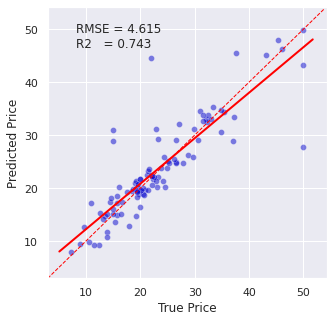

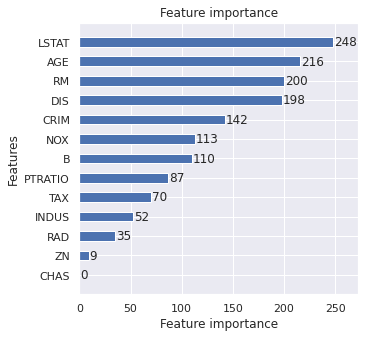

In [31]:
seed = 0
set_seeds(seed)
# Training APIデータセットの作成
X_train, y_train, X_test,  y_test = df_get_boston_train_test(train_size=0.8)
lgb_train = lgb.Dataset(X_train, y_train) # 学習用
lgb_test  = lgb.Dataset(X_test,  y_test)  # 評価用

# パラメータの設定
params = {
    'objective': 'regression', 
    'metric'   : 'rmse',
    'device'   :'gpu',
    'verbosity': -1
}

# LightGBMで学習
lgb_model = lgb.train(params, lgb_train)


# 評価データセットで予測
y_pred = lgb_model.predict(X_test)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
lgb.plot_importance(lgb_model, ignore_zero=False, height=0.5, figsize=(5,5))

### **2. LightGBM Training API** (lgb.train, valid_sets, num_boost_round)

検証用データセットでブースティング回数、検証用データセットを設定

```
valid_sets            = [lgb_valid], # 検証用データセット
num_boost_round       = 10000,       # ブースティングの反復回数
early_stopping_rounds = 100,         # 早期停止回数 (この回数の間に改善されない場合に打ち切り)
```

# Set seeds: 0

X_train/valid/test: retio=0.6/0.2/0.2, shape=(302, 13),(102, 13),(102, 13)

## Scores


,R2,MAE,MSE,RMSE
0,0.73751,2.898902,21.717274,4.66018


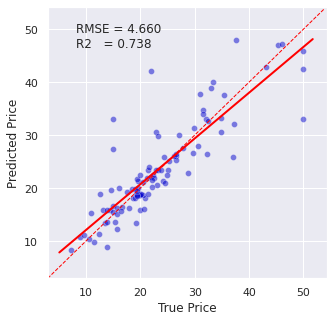

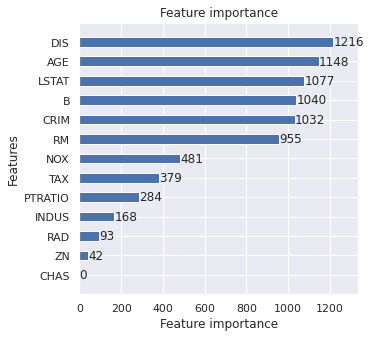

In [32]:
seed = 0
set_seeds(seed)
# Training APIデータセットの作成
X_train, y_train, X_valid, y_valid, X_test, y_test = \
                   df_get_boston_train_valid_test(train_size=0.6, valid_size=0.2)
lgb_train = lgb.Dataset(X_train, y_train)                      # 学習用
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train) # 検証用
lgb_test  = lgb.Dataset(X_test,  y_test)                       # 評価用

params = {
    'objective': 'regression', 
    'metric'   : 'rmse', 
    'device'   : 'gpu',
    'verbose'  : -1
}

# モデルの学習
lgb_model = lgb.train(
    params,
    lgb_train,                           # 学習用データセット
    valid_sets            = [lgb_valid], # 検証用データセット
    num_boost_round       = 10000,       # ブースティングの反復回数
    early_stopping_rounds = 100,         # 早期停止回数 (この回数の間に改善されない場合に停止)
    verbose_eval          = False
)

# 評価データセットで予測
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
lgb.plot_importance(lgb_model, ignore_zero=False, height=0.5, figsize=(5,5))

### **3. LightGBM CV API** (lgb.cv, folds)

LightGBMのクロスバリデーション機能を利用

```
folds                 = KFold(n_splits=5, shuffle=True, random_state=0), # for regression
  or
nfold                 = 5,           # Number of folds (=n_splits above)
shuffle               = True,
stratified            = False,

return_cvbooster      = True,
```

# Set seeds: 0

X_train/test: retio=0.8/None, size=(404, 13),(102, 13)
<class 'lightgbm.engine.CVBooster'>

## Scores


,R2,MAE,MSE,RMSE
0,0.774914,2.548662,18.622629,4.315394


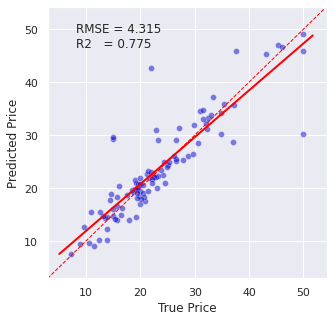

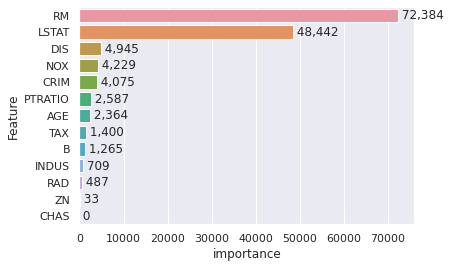

In [33]:
seed = 0
set_seeds(seed)
# Training APIデータセットの作成
X_train, y_train, X_test,  y_test = df_get_boston_train_test(train_size=0.8)
lgb_train = lgb.Dataset(X_train, y_train)                      # 学習用
lgb_test  = lgb.Dataset(X_test,  y_test)                       # 評価用

# ハイパーパラメータサーチ&モデル構築
params = {
    'objective'   : 'regression',
    'metric'      : 'rmse',
    'random_seed' : seed,
    'device'      : 'gpu',
    'verbosity'   : -1,
}

# クロスバリデーションによるハイパーパラメータの探索 3fold
cv_result = lgb.cv(
    params,
    lgb_train,
    folds                 = KFold(n_splits=5, shuffle=True, random_state=0), # for regression
    num_boost_round       = 10000,
    early_stopping_rounds = 100,
    return_cvbooster      = True,      # 学習済みモデルを取り出す
    seed                  = seed,
    verbose_eval          = -1,        # n行ごとにeval結果を出力、-1で最終結果, 0,False
)

cvbooster = cv_result['cvbooster']
print(type(cvbooster))

##-----------------------------------------
# prediction: cv毎の予測値の平均を取得
cv_pred = cvbooster.predict(X_test)           # [arr_1(n),   arr_2(n), ... arr_nfold]
cv_pred = [p.reshape(-1,1) for p in cv_pred]  # [arr_1(1,n), arr_2(1,n), ... arr_nfold]
arr_cv_pred = np.concatenate(cv_pred, axis=1) # arr(nfold,n)
mean_cv_pred = np.mean(arr_cv_pred, axis=1)

df_cv_pred = pd.DataFrame(data    = np.concatenate([arr_cv_pred, 
                                                    mean_cv_pred.reshape(-1,1)], 
                                                   axis=1),
                          columns = list(range(len(cv_pred)))+['mean'])
df_pred = pd.DataFrame({'true': y_test, 'predicted': mean_cv_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, mean_cv_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

##-----------------------------------------
# feature_importance
raw_importances = cvbooster.feature_importance(importance_type='gain') # CV事
df_raw_importance = pd.DataFrame(data = raw_importances, columns = X_train.columns)
# display(df_raw_importance)

df_importance = pd.DataFrame(df_raw_importance.T.mean(axis=1), columns=['importance'])
df_importance = df_importance.rename_axis('Feature').reset_index()
df_importance = df_importance.sort_values('importance', ascending=False).reset_index(drop=True)
#display(df_importance)

# 各説明変数の重要度を表示
sns.barplot(data=df_importance, x='importance', y='Feature')
for i in df_importance.index:
    ax = plt.text(y= i, 
             x= df_importance.loc[i,'importance'], 
             s= f' {df_importance.loc[i,"importance"]:,.0f}', 
             ha = 'left', va='center')

### **4. LightGBM scikit-learn API** (lgb.LGBMRegressor, fit)

LightGBMのscikit-learn APIを利用  
パラメータはデフォルト  

# Set seeds: 0

X_train/test: retio=0.8/None, size=(404, 13),(102, 13)

## Scores


,R2,MAE,MSE,RMSE
0,0.742355,2.671799,21.316456,4.616975


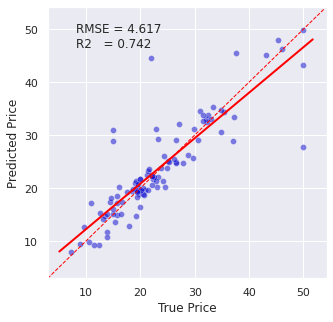

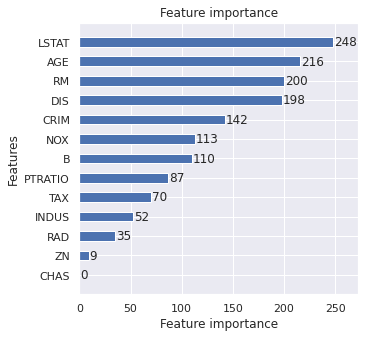

In [34]:
set_seeds()
# Training APIデータセットの作成
X_train, y_train, X_test, y_test = df_get_boston_train_test(train_size=0.8)

# LightGBMで学習
lgb_model = lgb.LGBMRegressor()
lgb_model = lgb_model.fit(
    X_train, y_train,
    eval_metric = 'rmse',
    verbose = False
)

# 評価データセットで予測
y_pred = lgb_model.predict(X_test)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
lgb.plot_importance(lgb_model, ignore_zero=False, height=0.5, figsize=(5,5))

### **5. LightGBM scikit-learn API - GridSearchCV** (lgb.LGBMRegressor, GridSearchCV, fit)

scikit-learn APIを利用し、scikit-learnの機能であるGridSearchCVから利用

# Set seeds: 0

X_train/valid/test: retio=0.6/0.2/0.2, shape=(302, 13),(102, 13),(102, 13)
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] seed is set=0, random_state=0 will be ignored. Current value: seed=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] seed is set=0, random_state=0 will be ignored. Current value: seed=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] seed is set=0, random_state=0 will be ignored. Current value: seed=0
[LightGBM] [Warning]

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'device': ['gpu'], 'early_stopping_round': [100],
                         'learning_rate': [0.05, 0.01],
                         'max_depth': [3, 5, 8, 12],
                         'min_data_in_leaf': [20, 30, 50],
                         'num_boost_round': [10000],
                         'num_leaves': [31, 15, 7, 3], 'seed': [0]},
             scoring='neg_mean_squared_error', verbose=False)

best_params:
{ 'device': 'gpu',
  'early_stopping_round': 100,
  'learning_rate': 0.05,
  'max_depth': 5,
  'min_data_in_leaf': 20,
  'num_boost_round': 10000,
  'num_leaves': 3,
  'seed': 0}

## Scores


,R2,MAE,MSE,RMSE
0,0.757504,2.849825,20.063082,4.479183


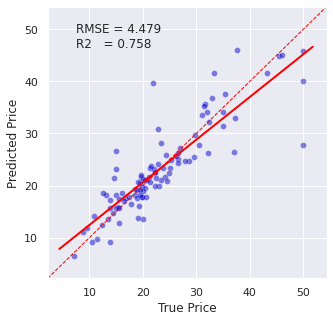

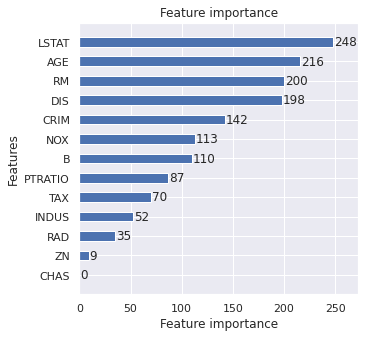

In [35]:
seed = 0
set_seeds(seed)
# データセットの作成
X_train, y_train, X_valid, y_valid, X_test, y_test = \
                   df_get_boston_train_valid_test(train_size=0.6, valid_size=0.2)

grid_param = {
    'num_boost_round'     : [10000],  # = num_iterations
    'early_stopping_round': [100],
    'num_leaves'      :[31,15,7,3],
    'min_data_in_leaf':[20, 30, 50],
    'max_depth'       :[3,5,8,12],
    'learning_rate'   :[0.05,0.01],
    'seed'            :[seed],
    'device'          :['gpu'],
}

bst_gs_cv = GridSearchCV(
    lgb.LGBMRegressor(random_state=seed),  # scikit-learn APIで呼ばれる
    grid_param,       # 最適化したいパラメータセット 
    cv          = KFold(n_splits=5, shuffle=True, random_state=seed), # for regression
    scoring     = 'neg_mean_squared_error',
    verbose     = False
)

bst_gs_cv.fit(
    X_train, 
    y_train,
    eval_set    = [(X_valid, y_valid)],
    eval_metric = 'rmse', 
    verbose     = False
)

best_params = bst_gs_cv.best_params_
print('best_params:')
pprint(best_params, indent=2, compact=True)
#pprint(best_params indent=2, compact=True, sort_dicts=False) # python 3.8 or later

# 評価データセットで予測
y_pred = bst_gs_cv.predict(X_test)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
lgb.plot_importance(lgb_model, ignore_zero=False, height=0.5, figsize=(5,5))

### **6. Optuna LightGBM Wrapper** (lgb_opt.train)

Optunaが提供する、LightGBMのラッパー  
「import lightgbm as lgb」を「import optuna.integration.lightgbm as lgb_opt」に変えるだけで、Optunaがチューニングしてくれる


# Set seeds: 0

X_train/valid/test: retio=0.6/0.2/0.2, shape=(302, 13),(102, 13),(102, 13)
best_params:
{ 'bagging_fraction': 0.5292109341630296,
  'bagging_freq': 3,
  'device': 'gpu',
  'early_stopping_round': 100,
  'feature_fraction': 0.9159999999999999,
  'feature_pre_filter': False,
  'lambda_l1': 0.011122475238865257,
  'lambda_l2': 1.068445694183594e-07,
  'metric': 'rmse',
  'min_child_samples': 20,
  'num_iterations': 10000,
  'num_leaves': 15,
  'objective': 'regression',
  'verbosity': -1}

## Scores


,R2,MAE,MSE,RMSE
0,0.730628,3.05879,22.286704,4.72088


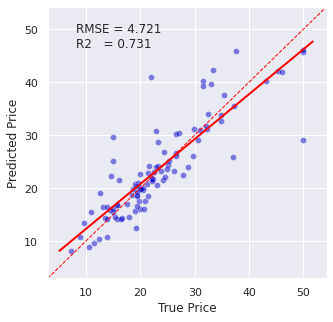

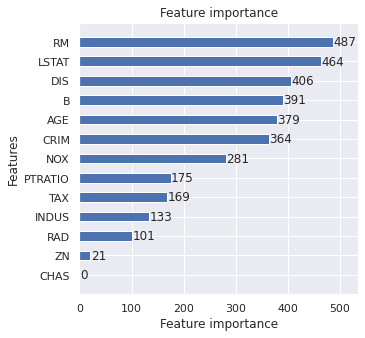

In [36]:
seed = 0
set_seeds(seed)
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()

# Training APIデータセットの作成
X_train, y_train, X_valid, y_valid, X_test,  y_test = \
                   df_get_boston_train_valid_test(train_size=0.6, valid_size=0.2)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

opt_params = {
    "objective": "regression",
    "metric"   : "rmse",
    'device'   : 'gpu',
    "verbosity": -1,
}

lgb_model = lgb_opt.train(   # Optuna経由でlightgbm.trainが呼ばれる
    opt_params,
    lgb_train,
    valid_sets            = [lgb_valid],
    num_boost_round       = 10000,        #ラウンド数
    early_stopping_rounds = 100,          #打ち切り
    verbose_eval          = False,
    show_progress_bar     = False

)

best_params = lgb_model.params
print('best_params:')
pprint(best_params, indent=2, compact=True)
#pprint(best_params indent=2, compact=True, sort_dicts=False) # python 3.8 or later

# 評価データセットで予測
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
lgb.plot_importance(lgb_model, ignore_zero=False, height=0.5, figsize=(5,5))

### **7. optuna LightGBMTuner Wrapper** (lgb_opt.LightGBMTuner)

optuna.integration.lightgbm.LightGBMTuner

# Set seeds: 0

X_train/valid/test: retio=0.6/0.2/0.2, shape=(302, 13),(102, 13),(102, 13)
best_params:
{ 'bagging_fraction': 0.44262163491880324,
  'bagging_freq': 1,
  'device': 'gpu',
  'feature_fraction': 0.4,
  'feature_pre_filter': False,
  'lambda_l1': 0.08649860535570786,
  'lambda_l2': 5.954611233038685,
  'metric': 'rmse',
  'min_child_samples': 20,
  'num_leaves': 140,
  'objective': 'regression',
  'random_state': 0,
  'verbosity': -1}

## Scores


,R2,MAE,MSE,RMSE
0,0.714975,3.248447,23.581746,4.856104


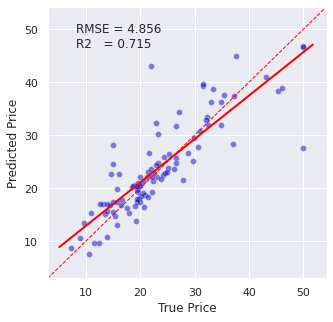

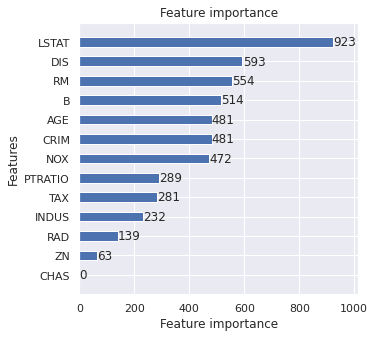

In [37]:
seed = 0
set_seeds(seed)
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()

X_train, y_train, X_valid, y_valid, X_test,  y_test = \
                   df_get_boston_train_valid_test(train_size=0.6, valid_size=0.2)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# ハイパーパラメータサーチ&モデル構築
params = {
    'objective'   : 'regression',
    'metric'      : 'rmse',
    'random_state': seed,
    'device'      : 'gpu',
    'verbosity'   : -1,
}

# クロスバリデーションによるハイパーパラメータの探索 3fold
lgb_model = lgb_opt.LightGBMTuner(
    params, 
    lgb_train, 
    valid_sets            = [lgb_valid],
    num_boost_round       = 10000,
    early_stopping_rounds = 100, 
    optuna_seed           = seed,
    verbose_eval          = False,  # n行ごとにeval結果を出力、-1で最終結果, 0,False
    show_progress_bar     = False,
)
# ハイパーパラメータ探索の実行
lgb_model.run()

best_params  = lgb_model.best_params
best_booster = lgb_model.best_booster
print('best_params:')
pprint(best_params, indent=2, compact=True)
#pprint(best_params indent=2, compact=True, sort_dicts=False) # python 3.8 or later

# 評価データセットで予測
y_pred  = best_booster.predict(X_test)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
lgb.plot_importance(best_booster, ignore_zero=False, height=0.5, figsize=(5,5))

### **8. Oputuna LightGBM-CV Wrapper** (lgb_opt.LightGBMTunerCV)

optuna.integration.lightgbm.LightGBMTunerCV

lgb.cv の代わりに、lgb_opt.LightGBMTunerCV を使用する

# Set seeds: 0

X_train/test: retio=0.8/None, size=(404, 13),(102, 13)
best_score: 2.9050543814762677
best_params:
{ 'bagging_fraction': 0.8750350228503905,
  'bagging_freq': 4,
  'device': 'gpu',
  'feature_fraction': 0.9799999999999999,
  'feature_pre_filter': False,
  'lambda_l1': 0.18554025303816857,
  'lambda_l2': 7.937648821932607,
  'metric': 'rmse',
  'min_child_samples': 5,
  'num_leaves': 5,
  'objective': 'regression',
  'random_seed': 0,
  'verbosity': -1}
<class 'lightgbm.engine.CVBooster'>

## Scores


,R2,MAE,MSE,RMSE
0,0.802211,2.2909,16.364242,4.045274


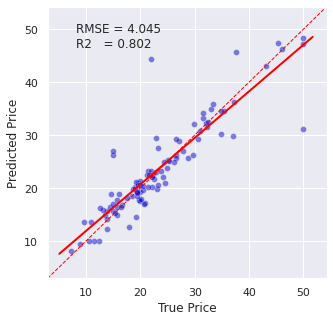

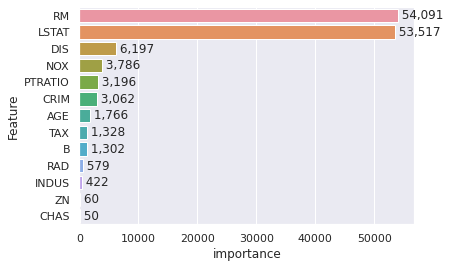

In [38]:
seed = 0
set_seeds(seed)
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()

X_train, y_train, X_test, y_test = df_get_boston_train_test(train_size=0.8)
lgb_train = lgb.Dataset(X_train, y_train)

# ハイパーパラメータサーチ&モデル構築
params = {'objective'  : 'regression',
          'metric'     : 'rmse',
          'random_seed': seed,
          'device'     : 'gpu',
          'verbosity'  : -1,
         }

# クロスバリデーションによるハイパーパラメータの探索 3fold
cv_result = lgb_opt.LightGBMTunerCV(
    params, 
    lgb_train, 
    num_boost_round       = 10000,
    early_stopping_rounds = 100, 
    folds             = KFold(n_splits=5, shuffle=True, random_state=seed), # for regression
    return_cvbooster  = True,
    seed              = seed,
    optuna_seed       = seed,
    verbose_eval      = False,  # n行ごとにeval結果を出力、-1で最終結果, 0,False
    show_progress_bar = False
)

# ハイパーパラメータ探索の実行
cv_result.run()
##-----------------------------------------

# サーチしたパラメータの表示
best_params = cv_result.best_params
print('best_score:',cv_result.best_score)
print('best_params:')
#pprint(cv_result.best_params, sort_dicts=False)
pprint(best_params, indent=2, compact=True)
#pprint(best_params indent=2, compact=True, sort_dicts=False) # python 3.8 or later


#cvbooster = cv_result['cvbooster']
cvbooster = cv_result.get_best_booster()
print(type(cvbooster))

##-----------------------------------------
# prediction: cv毎の予測値の平均を取得
cv_pred = cvbooster.predict(X_test)           # [arr_1(n),   arr_2(n), ... arr_nfold]
cv_pred = [p.reshape(-1,1) for p in cv_pred]  # [arr_1(1,n), arr_2(1,n), ... arr_nfold]
arr_cv_pred = np.concatenate(cv_pred, axis=1) # arr(nfold,n)
mean_cv_pred = np.mean(arr_cv_pred, axis=1)

df_cv_pred = pd.DataFrame(data    = np.concatenate([arr_cv_pred, 
                                                    mean_cv_pred.reshape(-1,1)], 
                                                   axis=1),
                          columns = list(range(len(cv_pred)))+['mean'])
df_pred = pd.DataFrame({'true': y_test, 'predicted': mean_cv_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, mean_cv_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

##-----------------------------------------
# feature_importance
raw_importances = cvbooster.feature_importance(importance_type='gain') # CV事
df_raw_importance = pd.DataFrame(data = raw_importances, columns = X_train.columns)
# display(df_raw_importance)

df_importance = pd.DataFrame(df_raw_importance.T.mean(axis=1), columns=['importance'])
df_importance = df_importance.rename_axis('Feature').reset_index()
df_importance = df_importance.sort_values('importance', ascending=False).reset_index(drop=True)
#display(df_importance)

# 各説明変数の重要度を表示
sns.barplot(data=df_importance, x='importance', y='Feature')
for i in df_importance.index:
    ax = plt.text(y= i, 
             x= df_importance.loc[i,'importance'], 
             s= f' {df_importance.loc[i,"importance"]:,.0f}', 
             ha = 'left', va='center')

### **9. Optuna - Scikit-learn GridSerchCV Wrapper** (OptunaSearchCV, LGBMRegressor)

optuna.integration.OptunaSearchCV  
Optunaが提供する、scikit-learnのGridSerchCVと同じに使えるOptunaSearchCVを使用

# Set seeds: 0

X_train/test: retio=0.8/None, size=(404, 13),(102, 13)
[LightGBM] [Warning] feature_fraction is set=0.6067384459913694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6067384459913694
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.07232339846520157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07232339846520157
[LightGBM] [Warning] lambda_l1 is set=0.03249124771297731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03249124771297731
[LightGBM] [Warning] bagging_fraction is set=0.8065057296414079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8065057296414079


OptunaSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
               estimator=LGBMRegressor(n_estimators=1000, random_state=0),
               n_jobs=-1, n_trials=100,
               param_distributions={'bagging_fraction': LogUniformDistribution(high=0.9, low=0.4),
                                    'bagging_freq': IntUniformDistribution(high=7, low=2, step=1),
                                    'feature_fraction': LogUniformDistribution(high=0.9, low=0.4),
                                    'lamb...
                                    'lambda_l2': LogUniformDistribution(high=0.5, low=0.001),
                                    'learning_rate': LogUniformDistribution(high=0.05, low=0.001),
                                    'max_depth': IntUniformDistribution(high=20, low=1, step=1),
                                    'min_child_samples': IntLogUniformDistribution(high=512, low=16, step=1),
                                    'num_leaves': IntLogUniformDistribution(

best_params:
{ 'bagging_fraction': 0.8065057296414079,
  'bagging_freq': 4,
  'feature_fraction': 0.6067384459913694,
  'lambda_l1': 0.03249124771297731,
  'lambda_l2': 0.07232339846520157,
  'learning_rate': 0.04736905261444059,
  'max_depth': 4,
  'min_child_samples': 16,
  'num_leaves': 25}

## Scores


,R2,MAE,MSE,RMSE
0,0.77675,2.432108,18.470748,4.297761


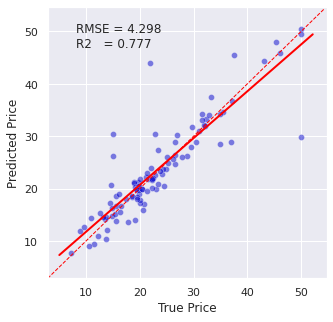

In [39]:
from optuna.integration import OptunaSearchCV
seed = 0
set_seeds(seed)
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()

X_train, y_train, X_test, y_test = df_get_boston_train_test(train_size=0.8)

# モデルの準備
lgb_model = lgb.LGBMRegressor(
    n_estimators = 1000,
    random_state = seed,
)

# 探索パラメータ範囲の設定
param_distributions = {
    'learning_rate'    :optuna.distributions.LogUniformDistribution(0.001, 0.05),
    'max_depth'        :optuna.distributions.IntUniformDistribution(1, 20, 1),
    'num_leaves'       :optuna.distributions.IntLogUniformDistribution(16, 96, 1),
    'min_child_samples':optuna.distributions.IntLogUniformDistribution(16, 512, 1),
    'lambda_l1'        :optuna.distributions.LogUniformDistribution(0.001, 0.5),
    'lambda_l2'        :optuna.distributions.LogUniformDistribution(0.001, 0.5),
    'feature_fraction' :optuna.distributions.LogUniformDistribution(0.4, 0.9),
    'bagging_fraction' :optuna.distributions.LogUniformDistribution(0.4, 0.9),
    'bagging_freq'     :optuna.distributions.IntUniformDistribution(2, 7, 1),
}

# クロスバリデーションによる、ハイパーパラメータの探索設定.cvのデフォルト設定値は5
optuna_search = OptunaSearchCV(
    lgb_model,
    param_distributions,
    scoring      = 'neg_root_mean_squared_error',
    cv           = KFold(n_splits=5, shuffle=True, random_state=seed), # for regression
    n_trials     = 100,
    random_state = seed,
    n_jobs       = -1,
    verbose      = -1
)

# 探索の実施
optuna_search.fit(X_train, y_train)

# 探索したベストパラメータの表示
best_params = optuna_search.best_params_
print('best_params:')
pprint(best_params, indent=2, compact=True)
#pprint(best_params indent=2, compact=True, sort_dicts=False) # python 3.8 or later

# 評価データセットで予測
y_pred = optuna_search.predict(X_test)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
# lgb.plot_importance(lgb_model, ignore_zero=False, height=0.5, figsize=(5,5))

### **10. Optuna Native API - lgb.train** (study, optimize, lgb.train)

import optuna

# Set seeds: 0
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=674 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=674 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=674 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=674 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=674 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=674 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=674 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=674 will be ignored. Current value: min_da

,R2,MAE,MSE,RMSE
0,0.788688,2.570619,17.483082,4.181278


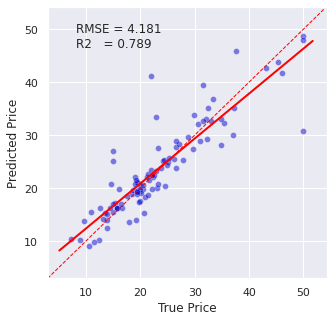

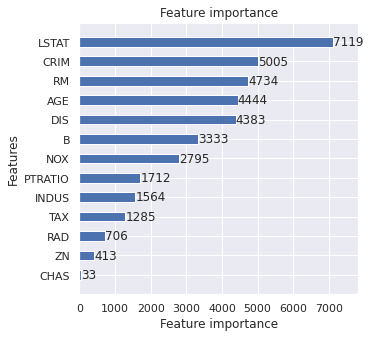

In [40]:
seed = 0
set_seeds(seed)
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()

X_train, y_train, X_valid, y_valid, X_test, y_test = \
                df_get_boston_train_valid_test(train_size=0.6, valid_size=0.2, dsp=False)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

def objective(trial):

    param = {
        'objective'    : 'regression',
        'boosting_type': 'gbdt',
        'metric'       : 'rmse',
        'device'       : 'gpu',
        'verbosity'    : -1,
        'max_depth'    : -1, 
        'num_boost_round'     : 10000,
        'early_stopping_round': 100,
        'feature_pre_filter'  : False,
        'num_leaves'       : trial.suggest_int(  'num_leaves',       2, 128),    # def=31
        'min_data_in_leaf' : trial.suggest_int(  'min_data_in_leaf', 8, 256),    # def=20
        'lambda_l1'        : trial.suggest_float('lambda_l1',        1e-8, 10.0, log=True),
        'lambda_l2'        : trial.suggest_float('lambda_l2',        1e-8, 10.0, log=True),
        'feature_fraction' : trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq'     : trial.suggest_int(  'bagging_freq',     1, 8),
        'min_child_samples': trial.suggest_int(  'min_child_samples',5, 1000),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    lgb_model = lgb.train(
        param, dtrain, 
        valid_sets = [dvalid], 
        callbacks    = [pruning_callback],
        verbose_eval = False, 
    )

    preds = lgb_model.predict(X_valid)
    y_pred = np.rint(preds)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    return rmse

#### Main ####
study = optuna.create_study(
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize"
)
study.optimize(objective, n_trials=500)

print(f"Number of finished trials: {len(study.trials)}")

best_trial  = study.best_trial
best_params = best_trial.params
print(f"Best trial:")
print(f"Value: {best_trial.value}")
print(f"Params: ")
pprint(best_params, indent=2, compact=True)
#pprint(best_params indent=2, compact=True, sort_dicts=False) # python 3.8 or later

    
#-------------------------------------------------------
# 学習データセットと検証データセットを結合し、再学習
lgb_train_valid = lgb.Dataset(pd.concat([X_train, X_valid], axis=0), 
                              pd.concat([y_train, y_valid], axis=0) )

# 再学習用パラメータの作成
#   best_trial.paramsには探索範囲を指定しなかったものは省略されているので追加
best_params = {
        'objective'    : 'regression',
        'boosting_type': 'gbdt',
        'metric'       : 'rmse',
        'device'       : 'gpu',
        'verbosity'    : -1,
        'max_depth'    : -1, 
        'num_boost_round'     : 10000,
        'feature_pre_filter'  : False,
}
best_params.update(best_trial.params)

lgb_model = lgb.train(
    best_params,
    lgb_train_valid
)

y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
lgb.plot_importance(lgb_model, ignore_zero=False, height=0.5, figsize=(5,5))

### **11. Optuna Native API - lgb.cv** (study, optimize, lgb.cv)

import optuna

# Set seeds: 0

X_train/test: retio=0.8/None, size=(404, 13),(102, 13)
Number of finished trials: 500
Best trial:
Value: 12.70903790644526
Params: 
{ 'bagging_fraction': 0.7406039298676281,
  'bagging_freq': 3,
  'feature_fraction': 0.5673982664968175,
  'lambda_l1': 5.438273579268724e-05,
  'lambda_l2': 0.002387139749891271,
  'min_child_samples': 174,
  'min_data_in_leaf': 38,
  'num_leaves': 130}

## Scores


,R2,MAE,MSE,RMSE
0,0.759393,2.895933,19.906831,4.461707


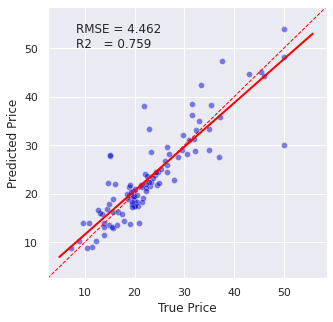

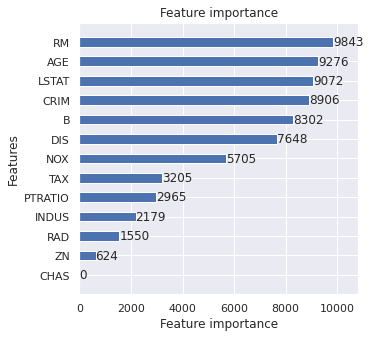

In [41]:
seed = 0
set_seeds(seed)
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()

X_train, y_train, X_test, y_test = df_get_boston_train_test(train_size=0.8)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

def objective(trial):

    param = {
        'objective'    : 'regression',
        'boosting_type': 'gbdt',
        'metric'       : 'rmse',
        'device'       : 'gpu',
        'verbosity'    : -1,
        'max_depth'    : -1, 
        'num_boost_round'     : 10000,
        'early_stopping_round': 100,
        'num_leaves'       : trial.suggest_int(  'num_leaves',       2, 128),    # def=31
        'min_data_in_leaf' : trial.suggest_int(  'min_data_in_leaf', 8, 256),    # def=20
        'lambda_l1'        : trial.suggest_float('lambda_l1',        1e-8, 10.0, log=True),
        'lambda_l2'        : trial.suggest_float('lambda_l2',        1e-8, 10.0, log=True),
        'feature_fraction' : trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq'     : trial.suggest_int(  'bagging_freq',     1, 7),
        'min_child_samples': trial.suggest_int(  'min_child_samples',5, 1000),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    cv_result = lgb.cv(
        params,
        lgb_train,
        folds                 = KFold(n_splits=5, shuffle=True, random_state=0), # for regression
        num_boost_round       = 10000,
        early_stopping_rounds = 100,
        callbacks             = [pruning_callback],
        return_cvbooster      = True,      # 学習済みモデルを取り出す
        seed                  = seed,
        verbose_eval          = -1,        # n行ごとにeval結果を出力、-1で最終結果, 0,False
    )
    cvbooster = cv_result['cvbooster']

    # prediction: cv毎の予測値の平均を取得
    cv_pred = cvbooster.predict(X_test)           # [arr_1(n),   arr_2(n),   ... arr_nfold]
    cv_pred = [p.reshape(-1,1) for p in cv_pred]  # [arr_1(1,n), arr_2(1,n), ... arr_nfold]
    arr_cv_pred = np.concatenate(cv_pred, axis=1) # arr(nfold,n)
    mean_cv_pred = np.mean(arr_cv_pred, axis=1)

    rmse = np.sqrt(mean_squared_error(y_valid, mean_cv_pred))
    return rmse

#### Main ####
study = optuna.create_study(
    pruner    = optuna.pruners.MedianPruner(n_warmup_steps=10), 
    direction ='minimize'
)
study.optimize(objective, n_trials=500)

print(f"Number of finished trials: {len(study.trials)}")

best_trial  = study.best_trial
best_params = best_trial.params
print(f"Best trial:")
print(f"Value: {best_trial.value}")
print(f"Params: ")
pprint(best_params, indent=2, compact=True)
#pprint(best_params indent=2, compact=True, sort_dicts=False) # python 3.8 or later

#-------------------------------------------------------
# 学習データセットと検証データセットを結合し、再学習
lgb_train_valid = lgb.Dataset(pd.concat([X_train, X_valid], axis=0), 
                              pd.concat([y_train, y_valid], axis=0) )

# 再学習用パラメータの作成
#   best_trial.paramsには探索範囲を指定しなかったものは省略されているので追加
best_params = {
        'objective'    : 'regression',
        'boosting_type': 'gbdt',
        'metric'       : 'rmse',
        'device'       : 'gpu',
        'verbosity'    : -1,
        'max_depth'    : -1, 
        'num_boost_round'     : 10000,
}
best_params.update(best_trial.params)

lgb_model = lgb.train(
    best_params,
    lgb_train_valid
)

y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
df_pred = pd.DataFrame({'true': y_test, 'predicted': y_pred})

# 結果
print(f'\n## Scores')
display(reg_scores.calc(y_test, y_pred))

# 予測誤差(true-pred)プロット
Prediction_accuracy(df_pred, 'true', 'predicted')

# 各説明変数の重要度を表示
lgb.plot_importance(lgb_model, ignore_zero=False, height=0.5, figsize=(5,5))

### **結果のまとめ**

In [42]:
display(reg_scores.get_all())

,R2,MAE,MSE,RMSE
0,0.742564,2.669224,21.299179,4.615103
1,0.737510,2.898902,21.717274,4.660180
2,0.774914,2.548662,18.622629,4.315394
3,0.742355,2.671799,21.316456,4.616975
4,0.757504,2.849825,20.063082,4.479183
5,0.730628,3.058790,22.286704,4.720880
6,0.714975,3.248447,23.581746,4.856104
7,0.802211,2.290900,16.364242,4.045274
8,0.776750,2.432108,18.470748,4.297761
9,0.788688,2.570619,17.483082,4.181278
